 <h1 style="color:black;"> Modeling Decision Tree, Random Forest, and XGBoost</h1>

<h2 style="color:black;">1. Load Dataset & Necessary Libraries</h2>

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

df = pd.read_csv('Customer-Churn-Records-Encoded-NoScaling.csv')

print("Dataset Overview:\n", df.head())
print("\nDataset Info:")
df.info()
print("\nMissing Values:\n", df.isnull().sum())

Dataset Overview:
    CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       1   42       2       0.00              1          1   
1          608       1   41       1   83807.86              1          0   
2          502       1   42       8  159660.80              3          1   
3          699       1   39       1       0.00              2          0   
4          850       1   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Churn  Satisfaction Score  Card Type  \
0               1        101348.88      1                   2        3.0   
1               1        112542.58      0                   3        3.0   
2               0        113931.57      1                   3        3.0   
3               0         93826.63      0                   5        1.0   
4               1         79084.10      0                   5        1.0   

   Point Earned  Geography_Germany  Geography_Spain  
0           4

<h2 style="color:black;">2. Identify the Target</h2>

In [2]:
target_col = 'Churn' X = df.drop(columns=[target_col])
y = df[target_col]

<h2 style="color:black;">3. Apply Undersampling</h2>

In [3]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

<h2 style="color:black;">4. Feature Selection using RFE</h2>

In [4]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf_selector, n_features_to_select=8)
X_resampled_rfe = rfe.fit_transform(X_resampled, y_resampled)
selected_features = X.columns[rfe.support_].tolist()
print("\nSelected Features using RFE:", selected_features)


Selected Features using RFE: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned']


<h2 style="color:black;">5. Data Partition</h2>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_rfe, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report

sns.set_style("whitegrid")

results = []

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_proba, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_true, y_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, color='red', lw=2, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.legend()
    plt.show()

def get_model_summary(y_true, y_pred, y_proba, dataset_name, model_name):
    summary = pd.DataFrame({
        "Dataset": [dataset_name],
        "Model": [model_name],
        "Accuracy": [accuracy_score(y_true, y_pred)],
        "Precision": [precision_score(y_true, y_pred)],
        "Recall": [recall_score(y_true, y_pred)],
        "F1 Score": [f1_score(y_true, y_pred)],
        "AUC-ROC": [auc(*roc_curve(y_true, y_proba)[:2])]
    })
    return summary

def train_and_evaluate(model, model_name, threshold=0.5):
    model.fit(X_train, y_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    best_threshold = max([0.3, 0.35, 0.4, 0.45, 0.5], key=lambda t: f1_score(y_test, (y_test_proba >= t).astype(int)))
    y_train_pred = (y_train_proba >= best_threshold).astype(int)
    y_test_pred = (y_test_proba >= best_threshold).astype(int)
    
    print(f"\n{model_name} Best Threshold: {best_threshold:.2f}")
    
    train_summary = get_model_summary(y_train, y_train_pred, y_train_proba, "Train", model_name)
    test_summary = get_model_summary(y_test, y_test_pred, y_test_proba, "Test", model_name)
    
    global results
    results.extend([train_summary, test_summary])
    
    results_df = pd.concat(results, ignore_index=True)
    display(results_df)
    
    plot_confusion_matrix(y_test, y_test_pred, model_name)
    plot_roc_curve(y_test, y_test_proba, model_name)
    plot_precision_recall_curve(y_test, y_test_proba, model_name)
    
    results_df.to_csv("model_comparison_results.csv", index=False)
    print("Model results saved to 'model_comparison_results.csv'")

<h2 style="color:black;">6. Decision Tree</h2


Optimized Decision Tree Best Threshold: 0.40


,Dataset,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Train,Optimized Decision Tree,0.759551,0.766739,0.746321,0.756392,0.833872
1,Test,Optimized Decision Tree,0.751431,0.752053,0.749591,0.750820,0.817060


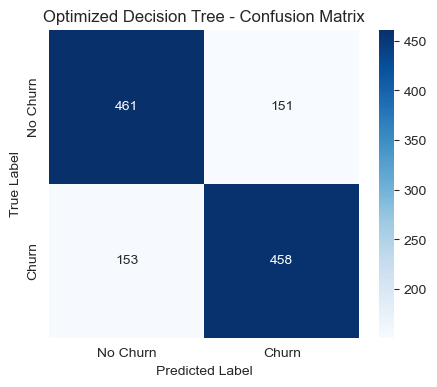

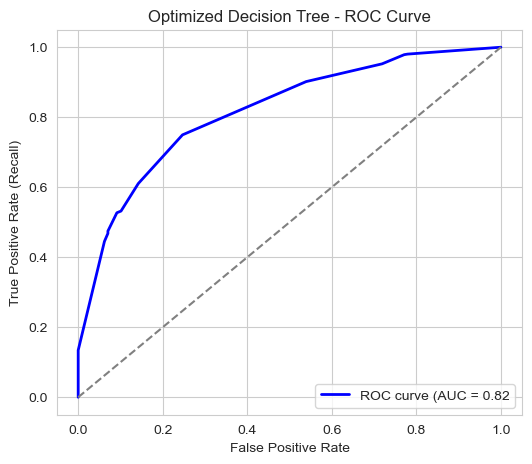

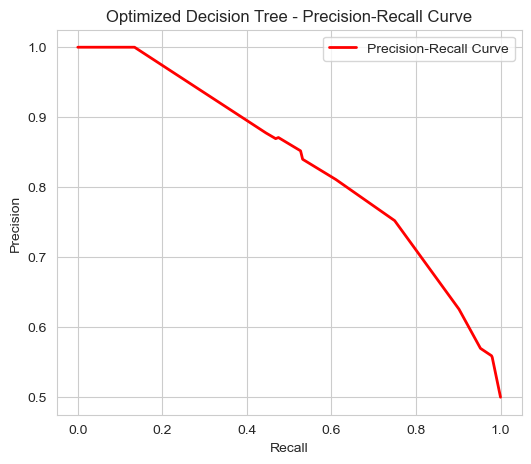

Model results saved to 'model_comparison_results.csv'


In [29]:
dt_params = {'max_depth': [4, 6, 8], 'min_samples_split': [5, 10, 20]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=2), dt_params, scoring='f1', cv=5)
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_
train_and_evaluate(dt_best, "Optimized Decision Tree", threshold=0.5)

<h2 style="color:black;">7. Random Forest</h2>


Optimized Random Forest Best Threshold: 0.45


,Dataset,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Train,Optimized Decision Tree,0.759551,0.766739,0.746321,0.756392,0.833872
1,Test,Optimized Decision Tree,0.751431,0.752053,0.749591,0.750820,0.817060
2,Train,Optimized Random Forest,0.872415,0.860339,0.889278,0.874569,0.943726
3,Test,Optimized Random Forest,0.743254,0.740681,0.747954,0.744300,0.820438


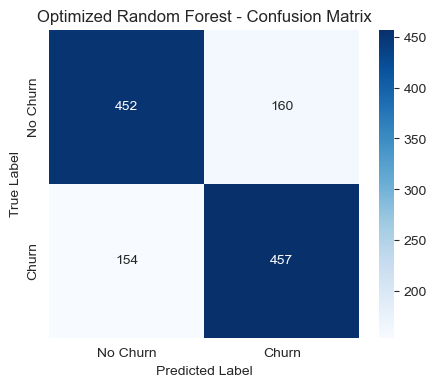

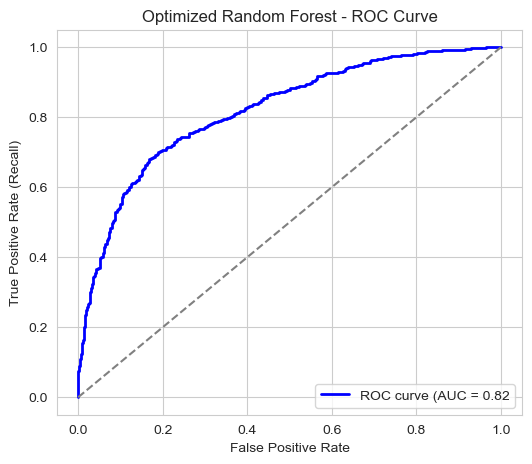

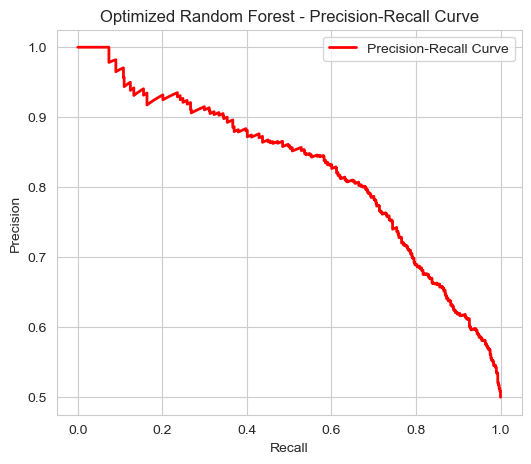

Model results saved to 'model_comparison_results.csv'


In [30]:
rf_params = {'n_estimators': [100, 200], 'max_depth': [6, 10], 'min_samples_split': [10, 15]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, max_features='sqrt'), rf_params, scoring='f1', cv=5)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
train_and_evaluate(rf_best, "Optimized Random Forest")

<h2 style="color:black;">8. XGBoost</h2>


Optimized XGBoost Best Threshold: 0.40


,Dataset,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Train,Optimized Decision Tree,0.759551,0.766739,0.746321,0.756392,0.833872
1,Test,Optimized Decision Tree,0.751431,0.752053,0.749591,0.750820,0.817060
2,Train,Optimized Random Forest,0.872415,0.860339,0.889278,0.874569,0.943726
3,Test,Optimized Random Forest,0.743254,0.740681,0.747954,0.744300,0.820438
4,Train,Optimized XGBoost,0.780231,0.744200,0.854240,0.795432,0.870969
5,Test,Optimized XGBoost,0.730989,0.692098,0.831424,0.755390,0.830809


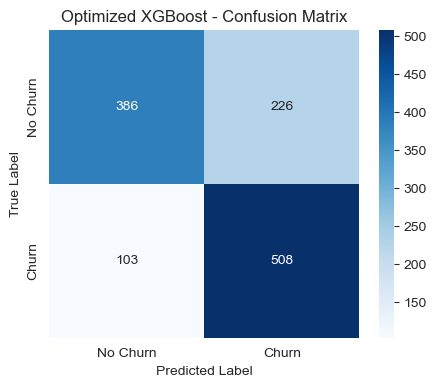

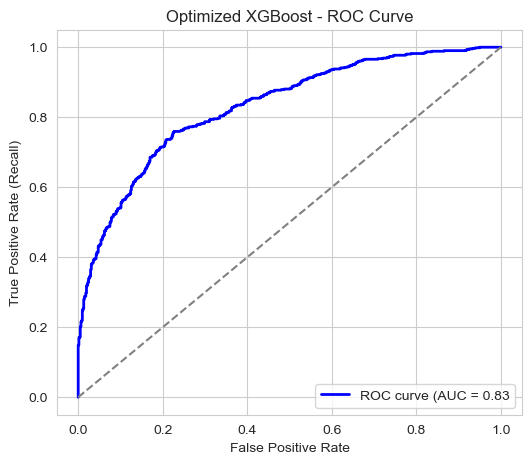

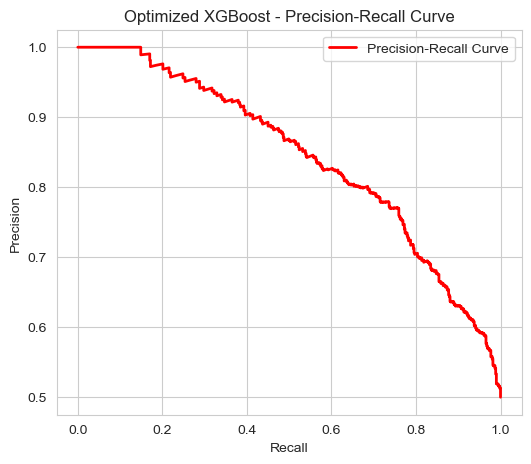

Model results saved to 'model_comparison_results.csv'


In [31]:
xgb_params = {'n_estimators': [100, 200], 'max_depth': [4, 6], 'learning_rate': [0.05, 0.1], 'min_child_weight': [1, 3]}
xgb_grid = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), xgb_params, scoring='f1', cv=5)
xgb_grid.fit(X_train, y_train)
xgb_best = xgb_grid.best_estimator_
train_and_evaluate(xgb_best, "Optimized XGBoost", threshold=0.4)